In [1]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special

####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2
        
    def forbidPhaseCrit(self, X):
        #return any([np.array([X])[...,0] < -5.0])
        return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])
    
    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot
    
    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end
 

        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys
     
    def old_boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

    
        #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])
        
        return M, dof, c, Mphys

    
    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))
        
        dof = np.array([12])
        return M, dof, Mphys
    

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        v = v2**.5
        return [np.array([v,self.u]), np.array([-v,-self.u]),np.array([v,-self.u]),np.array([-v,self.u])]
        #return [np.array([v,self.u]), np.array([-v,self.u])]
        #return []
        #return [np.array([v,self.u])]
    
    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and self.lammix<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False
            
        
    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")
        
    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0"""
        n=20
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            print("Model has a Z2 symmetry in the potential \n")
            print("isEWSB=True")
            return True
        for i in range(n):
            x1=np.random.uniform(0,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=m.Vtot(X_EW,0):
                break
        print("Global minimum found at X=",X0,"\n")
        delta_r=np.sum((X0-X_EW)**2)<1
        print("isEWSB=",delta_r,"\n")
        return delta_r 


    

####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')
    


def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum 
 ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity

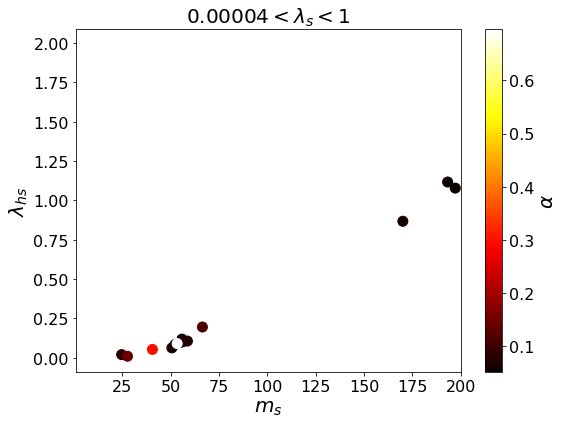

In [17]:
df=pd.read_csv("Scans_Zych/filtered_scan.csv",index_col=[0]).sort_values("alpha").drop_duplicates()
df=df[df.alpha>0.05]

thick_size=16
label_size=20
figure = plt.gcf()
figure.set_size_inches(8, 6)
cm = plt.cm.get_cmap('hot')
plt.scatter(df["ms"],df["lammix"],c=df["alpha"],s=100,cmap=cm)
plt.ylabel("$\lambda_{hs}$",size=label_size)
plt.xlabel("$m_{s}$",size=label_size)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=thick_size)
cb.set_label(label='$\\alpha$', size=label_size, weight='bold')
#plt.clim(.1,10)
plt.xlim(1,200)
plt.title("%0.5f"%df["lams"].min() + "$<\lambda_s <$%0.f"%df["lams"].max(),size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

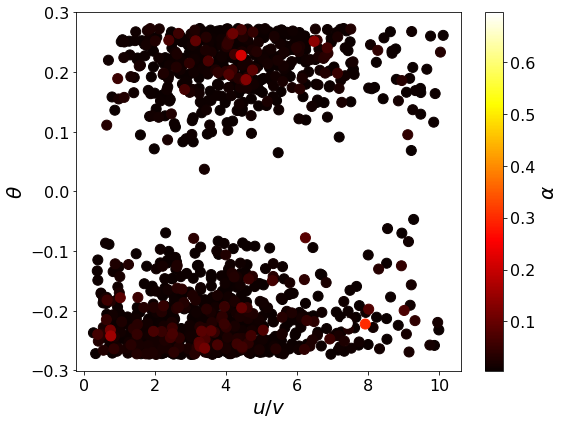

In [18]:
df=pd.read_csv("Scans_Zych/filtered_scan.csv",index_col=[0]).sort_values("alpha").drop_duplicates()
df=df[df.alpha>0.005]

thick_size=16
label_size=20
figure = plt.gcf()
figure.set_size_inches(8, 6)
cm = plt.cm.get_cmap('hot')
plt.scatter(df["u"]/v,df["theta"],c=df["alpha"],s=100,cmap=cm)
plt.xlabel("$u/v$",size=label_size)
plt.ylabel("$\\theta$",size=label_size)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=thick_size)
cb.set_label(label='$\\alpha$', size=label_size, weight='bold')
#plt.clim(df["alpha"].min(),.1)
#plt.title("%0.9f"%df["lams"].min() + "$<\lambda_s <$%0.f"%df["lams"].max(),size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

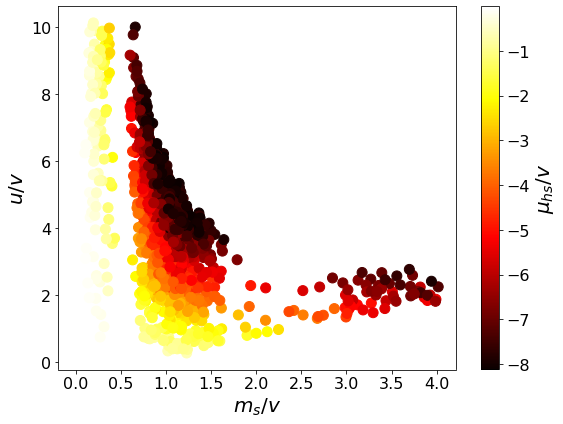

In [19]:
df=pd.read_csv("Scans_Zych/filtered_scan.csv",index_col=[0]).sort_values("alpha").drop_duplicates()
df=df[df.alpha>0.005]
#df=df[df.Tnuc<400]

thick_size=16
label_size=20
figure = plt.gcf()
figure.set_size_inches(8, 6)
cm = plt.cm.get_cmap('hot')
plt.scatter(df["ms"]/v,df["u"]/v,c=df["muhs"]/v,s=100,cmap=cm)
plt.ylabel("$u/v$",size=label_size)
plt.xlabel("$m_{s}/v$",size=label_size)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=thick_size)
cb.set_label(label='$\\mu_{hs}/v$', size=label_size, weight='bold')
#plt.clim(df["alpha"].min(),.1)
#plt.title("%0.9f"%df["lams"].min() + "$<\lambda_s <$%0.f"%df["lams"].max(),size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

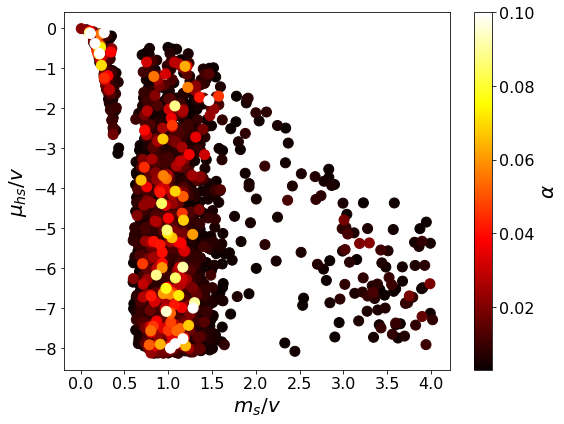

In [5]:
df=pd.read_csv("Scans_Zych/filtered_scan.csv",index_col=[0]).sort_values("alpha").drop_duplicates()
df=df[df.alpha>0.003]

thick_size=16
label_size=20
figure = plt.gcf()
figure.set_size_inches(8, 6)
cm = plt.cm.get_cmap('hot')
plt.scatter(df["ms"]/v,df["muhs"]/v,c=df["alpha"],s=100,cmap=cm)
plt.xlabel("$m_{s}/v$",size=label_size)
plt.ylabel("$\\mu_{hs}/v$",size=label_size)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=thick_size)
cb.set_label(label='$\\alpha$', size=label_size, weight='bold')
plt.clim(df["alpha"].min(),.1)
#plt.title("%0.9f"%df["lams"].min() + "$<\lambda_s <$%0.f"%df["lams"].max(),size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

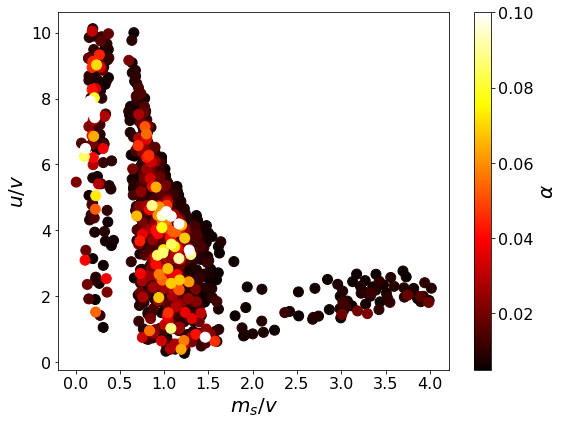

In [6]:
df=pd.read_csv("Scans_Zych/filtered_scan.csv",index_col=[0]).sort_values("alpha").drop_duplicates()
df=df[df.alpha>0.005]

thick_size=16
label_size=20
figure = plt.gcf()
figure.set_size_inches(8, 6)
cm = plt.cm.get_cmap('hot')
plt.scatter(df["ms"]/v,df["u"]/v,c=df["alpha"],s=100,cmap=cm)
plt.xlabel("$m_{s}/v$",size=label_size)
plt.ylabel("$u/v$",size=label_size)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=thick_size)
cb.set_label(label='$\\alpha$', size=label_size, weight='bold')
plt.clim(df["alpha"].min(),.1)
#plt.title("%0.9f"%df["lams"].min() + "$<\lambda_s <$%0.f"%df["lams"].max(),size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

In [2]:
#####
def my_getPhases(m):
    myexps=[(-5,-3),(-5,-5),(-5,-4),(-3,-3)]
    for nord in myexps:
        print("doing",nord)
        try:
            m.getPhases(tracingArgs={"dtstart":10**(nord[0]), "tjump":10**(nord[1])})
            phases_out=m.phases
        except:
            phases_out={}
        finally:
            if len(phases_out)>1:
                break
    return phases_out


def find_nucleation(m):
    """Find min and max temperatures to search for nucleation. IT will be used by bisection method.
    Parameters
        ----------
        m: a model instance. In this case m=model1(kk=1/600**2) for example.
    Returns
        -------
        nuc_dict: a dictionary containing the relevant temperatures and phases indexes. 
                It will be used by the other methods to find the nucleation and percolation parameters  
    """
    if m.phases is None:
        try:
            #phases_dict=m.getPhases()
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-3, "tjump":1e-3})
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-5, "tjump":1e-4})
            phases_dict=my_getPhases(m)
        except:
            return {}
    else:
        phases_dict=m.phases
    if len(phases_dict)<=1:
        return {}
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Num_relevant_trans=0
    ###DETERMINE IF THERE COULD BE TWO-STEP FOPTs
    for elem in crit_temps:
        if elem["trantype"]==1 and abs(elem["low_vev"][0]-elem["high_vev"][0])>10:
            print("Tunneling is relevant from phase " + str(elem["high_phase"])+ " to " + str(elem["low_phase"])  )
            Tmax=elem["Tcrit"]
            Tmin=phases_dict[elem["high_phase"]].T[0]
            print("max temperature is", Tmax)
            print("min temperature is", Tmin)
            Num_relevant_trans+=1
            high_phase_key=elem["high_phase"]
            low_phase_key=elem["low_phase"]
        else: 
            continue
    if Num_relevant_trans==0:
        dict_output={}
        return dict_output
    else:
        dict_output= {"Tmin":Tmin, "Tmax":Tmax, "high_phase": high_phase_key,"low_phase": low_phase_key}
    X0=m.phases[dict_output["high_phase"]].X[0]
    T0=m.phases[dict_output["high_phase"]].T[0]
    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    print("DOING WHILE LOOP \n")
    while stable:
        if T0<=0:
            break
        T0-=1e-4
        X0=m.findMinimum(X0,T0)
        if abs(X0[0])>0.1:
            break
        stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
        print(" ................. \n")
        if stable==False:
            break
    dict_output["Tmin"]=T0
    return dict_output




In [39]:
###Investigate what happens when ms=mh
# lammix_max=(2*mh**2)/v**2   ##max value of lammix obtained from lams>0
# lammix_val=lammix_max-.00001
# u_vev_range=np.linspace(.1,10,15)*v


# my_dicts=[]
# for u_vev in u_vev_range:
#     muhs_val=-(lammix_val)*u_vev
#     theta_rand=np.random.uniform(-0.3,0.3)
#     m=model1(ms = mh, theta = theta_rand, muhs= muhs_val , u = u_vev, mu3 = 0)
#     if abs(m.lamh)>2 and abs(m.lams)>2 and abs(m.lammix)>2:
#         print("Couplings are non perturbative")
#         continue
#     elif (m.lamh<=0) or (m.lams<=0) or (m.lammix<-2*(m.lamh*m.lams)**.5):
#         print("unbounded from below")
#         continue
#     else:
#         phases_dict=m.getPhases()
#         nuc_dict=find_nucleation(m)
#         try:
#             m.findAllTransitions()
#             phi_stable=m.TnTrans[-1]["low_vev"]
#             phi_meta=m.TnTrans[-1]["high_vev"]
#             Tnuc=m.TnTrans[-1]["Tnuc"]
#             Tc=m.TnTrans[-1]["crit_trans"]["Tcrit"]
#             Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
#             alpha=alpha_GW(Tnuc,Delta_rho)
#             dict_out={'ms':m.ms,'theta':m.theta, 'muhs':m.muhs,"u":m.u,"lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
#                      "h_low":phi_stable[0],"s_low":phi_stable[1],
#                      "h_high":phi_meta[0],"s_high":phi_meta[1],
#                      "Tc":Tc,"Tmin":nuc_dict["Tmin"],
#                       "Tnuc":Tnuc,"alpha":alpha}
#             my_dicts.append(dict_out)
#         except:
#             continue
        


In [40]:
####Investigate what happens when theta=mu3=0
#ms_val=v/2**0.5+74.1
#lammix_val=1
#lams_val=1
#u_val=(abs(ms_val**2-lammix_val*v**2/2))**0.5/(2*lams_val)**0.5
#muhs_val=-(lammix_val)*u_val

#m=model1(ms = ms_val, theta = 0, muhs= muhs_val , u = u_val, mu3 = 0)
#th_consistent=m.theory_consistent()
#m.print_couplings()


In [2]:
####Investigate what happens for Z2 symmetric case

theta_val=.266
ms_val=500
lammix_val=-.9
u_val=( mh**2- ms_val**2)*np.cos(theta_val)*np.sin(theta_val)/(lammix_val*v)
m=model1(ms = ms_val, theta = theta_val, muhs= 0 , u = u_val, mu3 = 0)

#df=pd.read_csv("Scans_Zych/new_filtered_scan.csv",index_col=[0])
#i=np.random.randint(0,len(df))
#i=0
#print("Looking at benchmark number=",i)
#m=model1(ms = df.iloc[i].ms, theta =- df.iloc[i].theta, muhs= df.iloc[i].muhs , u = df.iloc[i].u, mu3 = df.iloc[i].mu3)


#m=model1(ms= 129.95742526609794, theta=0.24348339942312264, muhs= -37.64011156860533, u = -405.87187707472964, mu3= 0)
#m=model1(ms= 129.95742526609794, theta=0.24348339942312264, muhs= -37.64011156860533, u = 405.87187707472964, mu3= 0)
#m=model1(ms=339.60871474668363, theta=-0.20886912504762015, muhs= 184.21751975297275, u=402.1959536402746)

th_consistent=m.theory_consistent()
m.print_couplings()
m.isEWSB()

Model is theoretically consistent 

Potential parameters are given by 
 
mus2= 89626.28821592455 muh2= -16459.884092280103 lamh= 0.2626596539384912 lams= 1.6246099366628641 lammix= -0.9 

Model parameters are 

ms= 500 theta= 0.266 muhs= 0 u= 268.24885596258287 mu3= 0 

Model has a Z2 symmetry in the potential 

isEWSB=True


True

In [3]:
phases_dict=m.getPhases(tracingArgs={"dtstart":1e-5, "tjump":1e-5})
#phases_dict=m.getPhases()
#nuc_dict=find_nucleation(m)


Tracing phase starting at x = [246.20000226 268.24885593] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..........................................................................................................................................
Tracing phase starting at x = [ 29.22454845 234.5275992 ] ; t = 162.8629350838833
Tracing minimum down
traceMinimum t0 = 162.863
...............................................................................................................................................................................
Tracing minimum up
traceMinimum t0 = 162.863
....................................................
Tracing phase starting at x = [9.99447682e-04 2.34018161e+02] ; t = 163.03462891355866
Tracing minimum down
traceMinimum t0 = 163.035
.............................................
Tracing minimum up
traceMinimum t0 = 163.035
..............................................................................................................................

NotImplementedError: Two phases have been found to coincide at one end but not the other. Ideally, this function would find where the two diverge, make a cut, and join them such there are no more phase redundancies.
Instead, just raise an exception.

In [4]:
m.phases

{1: Phase(key=1, X=[[246.2 268.2], ..., [18.64 234.2]], T=[0, ..., 163], dXdT=[[-0 -0], ..., [-1255 -27.65]],
 2: Phase(key=2, X=[[0.008874 234], ..., [-4.314e-05 165.7]], T=[163, ..., 463], dXdT=[[-2.198 -0.03251], ..., [1.154e-05 -0.8108]],
 3: Phase(key=3, X=[[4.583e-05 162.4], ..., [-0.0003214 110]], T=[462.9, ..., 507.3], dXdT=[[0.0001227 -0.5661], ..., [-0.002347 -14.22]],
 4: Phase(key=4, X=[[3.127e-05 0.02025], ..., [0.0001776 0.0003473]], T=[495.5, ..., 1000], dXdT=[[0.0001747 -0.1804], ..., [-0.0009685 -0.0001177]],
 5: Phase(key=5, X=[[0.0005625 84.89], ..., [0.0001352 -0.0001378]], T=[450, ..., 1000], dXdT=[[-1.83e-05 -0.9166], ..., [0.0004858 0.0001441]]}

In [6]:
print("Phases coexisiting with dT=",)
high_index=5
low_index=4
m.phases[low_index].T[-1]-m.phases[high_index].T[0]

Phases coexisiting with dT=


550.0438324869485

In [7]:
#m.phases={high_index:m.phases[high_index],low_index:m.phases[low_index]}
m.findAllTransitions()


Tunneling from phase 5 to phase 2 at T=449.9562
high_vev = [-5.42966812e-06  8.48889684e+01]
low_vev = [-1.12752483e-04  1.74739507e+02]
Path deformation converged. 1 steps. fRatio = 2.79956e-06
Tunneling from phase 5 to phase 4 at T=1000
high_vev = [ 0.00013518 -0.0001378 ]
low_vev = [ 6.07663573e-05 -5.37285492e-05]


IntegrationError: r > rmax

In [14]:
len(m.TnTrans),m.TnTrans[0]

(2,
 {'Tnuc': 165.13463720818825,
  'low_vev': array([ 7.93723967e-03, -2.69515767e-06]),
  'high_vev': array([ 7.93723967e-03, -2.69515767e-06]),
  'low_phase': 1,
  'high_phase': 2,
  'action': 0.0,
  'instanton': None,
  'trantype': 2,
  'crit_trans': {'Tcrit': 165.13463720818825,
   'low_vev': array([ 7.93723967e-03, -2.69515767e-06]),
   'high_vev': array([ 7.93723967e-03, -2.69515767e-06]),
   'low_phase': 1,
   'high_phase': 2,
   'action': 0.0,
   'instanton': None,
   'trantype': 2,
   'Delta_rho': 0.0},
  'Delta_rho': 0.0,
  'Delta_p': 0.0})

In [15]:
###Select only FOPT
for elem in m.TnTrans:
    if elem["trantype"]==1:
        break
elem     

{'low_vev': array([182.71603672, -27.46633531]),
 'high_vev': array([ 1.78177496e+02, -2.76352666e-06]),
 'Tnuc': 125.18037385090558,
 'low_phase': 3,
 'high_phase': 1,
 'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.        , 0.00515147, 0.01028484, 0.01540013, 0.02049732,
        0.02557643, 0.03063744, 0.03568036, 0.04070519, 0.04571193,
        0.05070058, 0.05567113, 0.0606236 , 0.06555797, 0.07047426,
        0.07537245, 0.08025255, 0.08511457, 0.08995849, 0.09478431,
        0.09959205, 0.1043817 , 0.10915326, 0.11390672, 0.1186421 ,
        0.12335938, 0.12805857, 0.13273967, 0.13740268, 0.1420476 ,
        0.14667443, 0.15128317, 0.15587381, 0.16044637, 0.16500083,
        0.16953721, 0.17405549, 0.17855568, 0.18303778, 0.18750179,
        0.19194771, 0.19637554, 0.20078527, 0.20517692, 0.20955047,
        0.21390593, 0.21824331, 0.22256259, 0.22686378, 0.23114688,
        0.23541189, 0.2396588 , 0.24388763, 0.24809837, 0.25229101,
        0.25646556, 0.2606220

In [16]:
alltrans=elem
Tn=alltrans['Tnuc']
Delta_rho=alltrans['Delta_rho']
alpha_GW(Tn,Delta_rho)

0.0004396900602506393

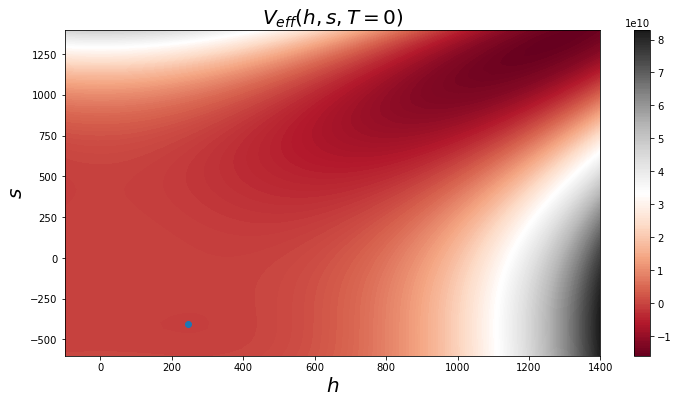

In [13]:
clevs=50
myN = 200
Temp=0
box=(-100,1400,-600,1400)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + ")",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
ax1.scatter(v,m.u)
fig.colorbar(cf1, ax=ax1)

plt.show()

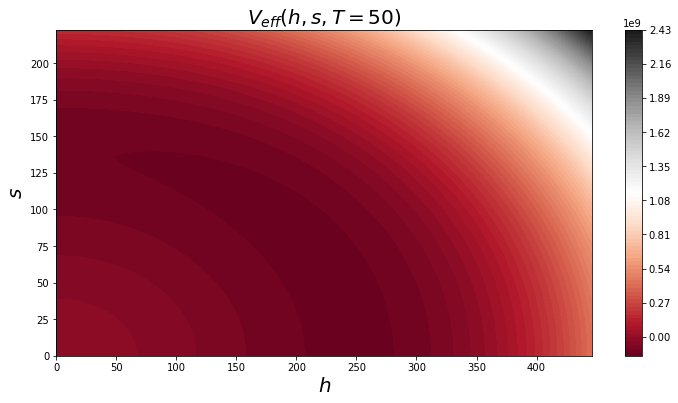

In [234]:
clevs=50
myN = 100
Temp=50
box=(-0,v+200,0,m.u+200)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + ")",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
#ax1.scatter(v,m.u)
fig.colorbar(cf1, ax=ax1)

plt.show()

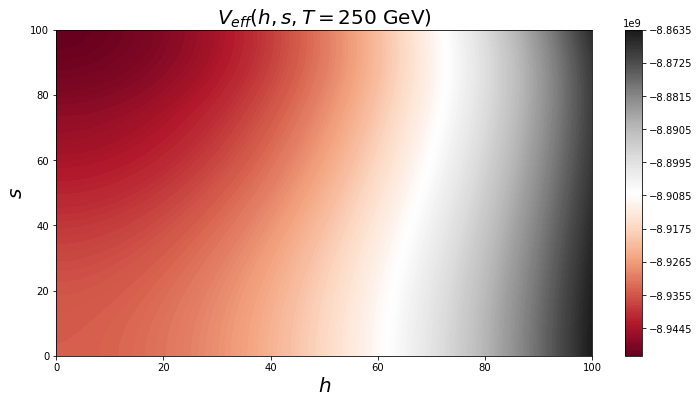

In [255]:
clevs=50
myN = 200
Temp=250
box=(-0,100,0,100)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + " GeV)",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
#ax1.scatter(v,m.u)
fig.colorbar(cf1, ax=ax1)

plt.show()